In [1]:
import torch
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch

class RAFDBDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
from rafdb_dataset import RAFDBDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(), 
    # transforms.RandomApply([
    #     transforms.RandomRotation(5),
    #     transforms.RandomCrop(64, padding=8)
    # ], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomErasing(scale=(0.02,0.25)),
])
    
rafdb_dataset_train = RAFDBDataset(csv_file='data/train_labels.csv',
                            img_dir='data/train/',
                            transform=transform)
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=16, shuffle=True, num_workers=4)
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

rafdb_dataset_vali = RAFDBDataset(csv_file='data/vali_labels.csv',
                            img_dir='data/vali',
                            transform=transform)
data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=16, shuffle=False, num_workers=0)
vali_image, vali_label = next(iter(data_vali_loader))
print(f"Vali batch: image shape {vali_image.shape}, labels shape {vali_label.shape}")

rafdb_dataset_test = RAFDBDataset(csv_file='data/test_RAF_labels.csv',
                            img_dir='data/test/',
                            transform=transform)
data_test_loader = DataLoader(rafdb_dataset_test, batch_size=16, shuffle=False, num_workers=0)
test_image, test_label = next(iter(data_test_loader))
print(f"Test batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Vali batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Test batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])


In [4]:
class SEBlock(nn.Module): # Squeeze-and-Excitation (SE) blocks apply channel-wise attention.
    def __init__(self, input_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_channels, input_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_channels // reduction, input_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        out = F.relu(out)
        return out

In [6]:
# # Residual 
# class EmotionClassifier(nn.Module):
#     def __init__(self):
#         super(EmotionClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.se1 = SEBlock(64)

#         # Using Residual Blocks
#         self.res_block1 = ResidualBlock(64, 128, stride=2)
#         self.res_block2 = ResidualBlock(128, 256, stride=2)
#         self.res_block3 = ResidualBlock(256, 512, stride=2)
#         self.res_block4 = ResidualBlock(512, 1024, stride=2)

#         self.pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc1 = nn.Linear(1024, 2048)
#         self.fc2 = nn.Linear(2048, 1024) 
#         self.dropout1 = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(1024, 6)

#     def forward(self, x):
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.se1(x)
        
#         x = self.res_block1(x)
#         x = self.res_block2(x)
#         x = self.res_block3(x)
#         x = self.res_block4(x)
        
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# model = EmotionClassifier().to(device)

In [7]:
# model.load_state_dict(torch.load('best_baseline.pth', map_location=device))
# model.eval()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def EmotionClassifierResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

model = EmotionClassifierResNet18().to(device)


In [9]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 11179590


In [10]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

patience = 9
best_val_acc = 0  
patience_counter = 0

num_epochs = 70

In [11]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(data_train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in data_test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(data_test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in data_vali_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(data_vali_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    if patience_counter > patience:
        print("Stopping early due to lack of improvement in validation accuracy.")
        break

Epoch 1/70: 100%|██████████| 3442/3442 [02:48<00:00, 20.45it/s]


Epoch 1, Train Loss: 1.3421774735151508, Train Accuracy: 0.4687948284941258, Test Loss: 0.8872695792218049, Test Accuracy: 0.6987850858818601, Validation Loss: 1.462745062614742, Validation Accuracy: 0.44407345575959933


Epoch 2/70: 100%|██████████| 3442/3442 [02:41<00:00, 21.33it/s]


Epoch 2, Train Loss: 1.0459993128112275, Train Accuracy: 0.5893664542136514, Test Loss: 0.7721815560013056, Test Accuracy: 0.7406786761625471, Validation Loss: 1.655601807330784, Validation Accuracy: 0.49081803005008345


Epoch 3/70: 100%|██████████| 3442/3442 [02:45<00:00, 20.84it/s]


Epoch 3, Train Loss: 0.9301138101778773, Train Accuracy: 0.6385756568793013, Test Loss: 0.612294404655695, Test Accuracy: 0.796397151235861, Validation Loss: 1.1902799935717332, Validation Accuracy: 0.5776293823038398


Epoch 4/70: 100%|██████████| 3442/3442 [02:43<00:00, 21.06it/s]


Epoch 4, Train Loss: 0.854427894011339, Train Accuracy: 0.6702620253854116, Test Loss: 0.5349888997897506, Test Accuracy: 0.8169250104733976, Validation Loss: 1.0180035358981083, Validation Accuracy: 0.6310517529215359


Epoch 5/70: 100%|██████████| 3442/3442 [02:43<00:00, 21.05it/s]


Epoch 5, Train Loss: 0.7985381194926638, Train Accuracy: 0.6933594813967424, Test Loss: 0.5519284878795345, Test Accuracy: 0.8190196899874319, Validation Loss: 1.0750680220754523, Validation Accuracy: 0.6260434056761269
No improvement in validation accuracy for 1 epochs.


Epoch 6/70: 100%|██████████| 3442/3442 [02:42<00:00, 21.12it/s]


Epoch 6, Train Loss: 0.755168426758082, Train Accuracy: 0.7088667356685007, Test Loss: 0.4775544639211148, Test Accuracy: 0.8399664851277755, Validation Loss: 0.9001396714072478, Validation Accuracy: 0.6844741235392321


Epoch 7/70: 100%|██████████| 3442/3442 [02:44<00:00, 20.96it/s]


Epoch 7, Train Loss: 0.7104836753085212, Train Accuracy: 0.7288954259047411, Test Loss: 0.5109264511739214, Test Accuracy: 0.8290741516547968, Validation Loss: 0.9337097202476702, Validation Accuracy: 0.6928213689482471


Epoch 8/70: 100%|██████████| 3442/3442 [02:44<00:00, 20.94it/s]


Epoch 8, Train Loss: 0.6681088151032498, Train Accuracy: 0.7450019066296236, Test Loss: 0.514015147263805, Test Accuracy: 0.8290741516547968, Validation Loss: 0.9461427425083361, Validation Accuracy: 0.671118530884808
No improvement in validation accuracy for 1 epochs.


Epoch 9/70: 100%|██████████| 3442/3442 [02:43<00:00, 21.06it/s]


Epoch 9, Train Loss: 0.6264860498773573, Train Accuracy: 0.7621978899965499, Test Loss: 0.5355987157300115, Test Accuracy: 0.8261416003351487, Validation Loss: 0.927717814712148, Validation Accuracy: 0.6828046744574291
No improvement in validation accuracy for 2 epochs.


Epoch 10/70: 100%|██████████| 3442/3442 [02:43<00:00, 21.11it/s]


Epoch 10, Train Loss: 0.5903781196172849, Train Accuracy: 0.7748361206442592, Test Loss: 0.5253690998069942, Test Accuracy: 0.8236279849183075, Validation Loss: 0.9455317039238779, Validation Accuracy: 0.6844741235392321
No improvement in validation accuracy for 3 epochs.


Epoch 11/70: 100%|██████████| 3442/3442 [02:43<00:00, 20.99it/s]


Epoch 11, Train Loss: 0.5475846002357841, Train Accuracy: 0.793194240162699, Test Loss: 0.5290337331903477, Test Accuracy: 0.8336824465856724, Validation Loss: 1.056104034969681, Validation Accuracy: 0.667779632721202
No improvement in validation accuracy for 4 epochs.


Epoch 12/70: 100%|██████████| 3442/3442 [02:42<00:00, 21.12it/s]


Epoch 12, Train Loss: 0.5106431259137818, Train Accuracy: 0.8073759328866372, Test Loss: 0.5664779924725493, Test Accuracy: 0.8253037285295349, Validation Loss: 0.8367366353540044, Validation Accuracy: 0.7378964941569283


Epoch 13/70: 100%|██████████| 3442/3442 [02:43<00:00, 21.10it/s]


Epoch 13, Train Loss: 0.4720926593896056, Train Accuracy: 0.8226834450073541, Test Loss: 0.4905237541906536, Test Accuracy: 0.8391286133221617, Validation Loss: 0.8829178766984689, Validation Accuracy: 0.7145242070116862
No improvement in validation accuracy for 1 epochs.


Epoch 14/70: 100%|██████████| 3442/3442 [02:43<00:00, 21.11it/s]


Epoch 14, Train Loss: 0.437159753921899, Train Accuracy: 0.837627789580723, Test Loss: 0.540108880251646, Test Accuracy: 0.8374528697109342, Validation Loss: 0.8387782903094041, Validation Accuracy: 0.7312186978297162
No improvement in validation accuracy for 2 epochs.


Epoch 15/70: 100%|██████████| 3442/3442 [02:43<00:00, 21.00it/s]


Epoch 15, Train Loss: 0.40047443739286276, Train Accuracy: 0.8538613789471773, Test Loss: 0.5614259774688011, Test Accuracy: 0.8294930875576036, Validation Loss: 1.1377197802066803, Validation Accuracy: 0.6844741235392321
No improvement in validation accuracy for 3 epochs.


Epoch 16/70: 100%|██████████| 3442/3442 [02:47<00:00, 20.52it/s]


Epoch 16, Train Loss: 0.37301680114486063, Train Accuracy: 0.8625229249514264, Test Loss: 0.5718379813432694, Test Accuracy: 0.8328445747800587, Validation Loss: 1.041297989456277, Validation Accuracy: 0.6978297161936561
No improvement in validation accuracy for 4 epochs.


Epoch 17/70: 100%|██████████| 3442/3442 [02:48<00:00, 20.46it/s]


Epoch 17, Train Loss: 0.3412539411924957, Train Accuracy: 0.8767772511848341, Test Loss: 0.589450880564594, Test Accuracy: 0.8366149979053205, Validation Loss: 1.1424532956198643, Validation Accuracy: 0.6944908180300501
No improvement in validation accuracy for 5 epochs.


Epoch 18/70: 100%|██████████| 3442/3442 [02:46<00:00, 20.65it/s]


Epoch 18, Train Loss: 0.311521211056226, Train Accuracy: 0.8876359608505384, Test Loss: 0.6025402763447103, Test Accuracy: 0.8366149979053205, Validation Loss: 0.9792454397599948, Validation Accuracy: 0.7378964941569283
No improvement in validation accuracy for 6 epochs.


Epoch 19/70: 100%|██████████| 3442/3442 [02:42<00:00, 21.15it/s]


Epoch 19, Train Loss: 0.2883831094393051, Train Accuracy: 0.8975685932705053, Test Loss: 0.5403193578620752, Test Accuracy: 0.8458315877670717, Validation Loss: 1.056268027738521, Validation Accuracy: 0.7228714524207012
No improvement in validation accuracy for 7 epochs.


Epoch 20/70: 100%|██████████| 3442/3442 [02:41<00:00, 21.38it/s]


Epoch 20, Train Loss: 0.27522974744420725, Train Accuracy: 0.9010005265929436, Test Loss: 0.5778870777960401, Test Accuracy: 0.8496020108923334, Validation Loss: 1.1476116305903385, Validation Accuracy: 0.7245409015025042
No improvement in validation accuracy for 8 epochs.


Epoch 21/70: 100%|██████████| 3442/3442 [02:41<00:00, 21.29it/s]


Epoch 21, Train Loss: 0.25520832175962554, Train Accuracy: 0.9095531223329884, Test Loss: 0.5858346934961931, Test Accuracy: 0.8433179723502304, Validation Loss: 1.1012953084550405, Validation Accuracy: 0.7145242070116862
No improvement in validation accuracy for 9 epochs.


Epoch 22/70: 100%|██████████| 3442/3442 [02:41<00:00, 21.26it/s]


Epoch 22, Train Loss: 0.23627737357932155, Train Accuracy: 0.9165985727515389, Test Loss: 0.624953377667504, Test Accuracy: 0.8433179723502304, Validation Loss: 1.2246651559283859, Validation Accuracy: 0.7195325542570952
No improvement in validation accuracy for 10 epochs.
Stopping early due to lack of improvement in validation accuracy.


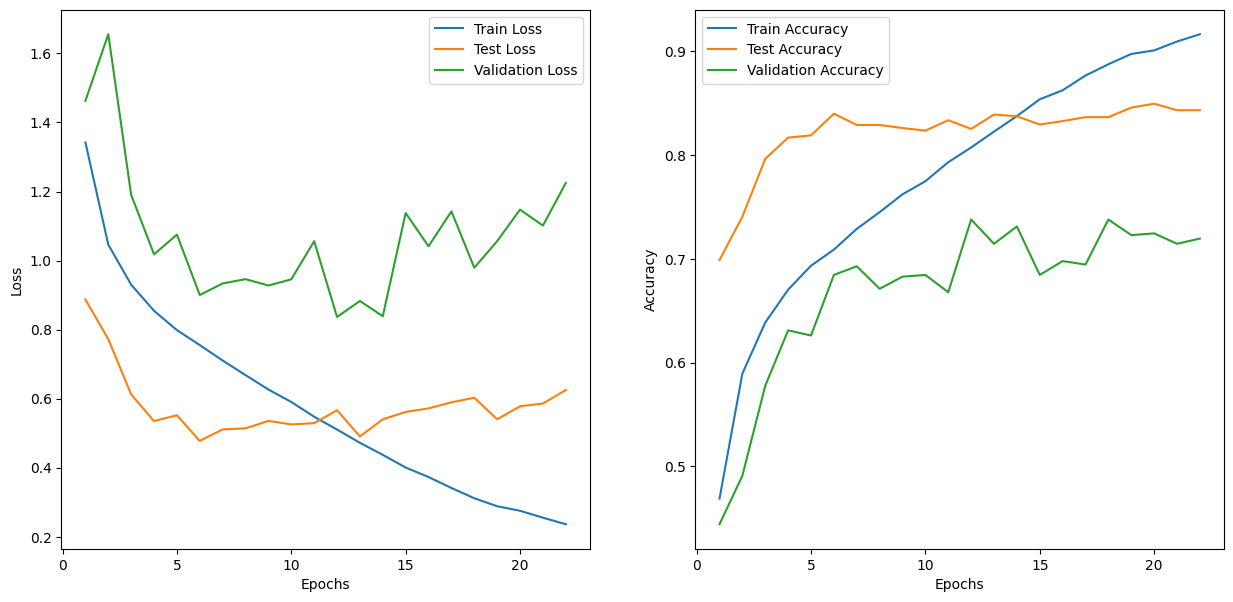

In [13]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, 23), train_losses, label='Train Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 23), test_losses, label='Test Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 23), val_losses, label='Validation Loss') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.title('Losses on ') # change
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 23), train_accuracies, label='Train Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 23), test_accuracies, label='Test Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 23), val_accuracies, label='Validation Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.title('Accuracies on RAF-DB') # change
plt.legend()

plt.show()

In [ ]:
df = pd.DataFrame({
    'Epoch': range(1, 23), # change this number after '(1, _)' to num_epochs+1
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies
})
df.to_csv('result_SGD_res18.csv', index=False) # change this CSV